In [1]:
import numpy as np
import matplotlib.pyplot as plt

import supervisely_lib as sly

from tqdm import tqdm
from collections import defaultdict

%matplotlib inline

In [2]:
address = 'http://192.168.1.69:5555'
token = 'YGPDnuBkhFmcQ7VNzSEjhgavjg4eFR4Eq1C3jIY4HgV3SQq2JgkXCNtgZy1Fu2ftd4IKui8DsjrdtXjB853cMtBevpSJqFDYiaG1A5qphlH6fFiYYmcVZ5fMR8dDrt5l'
team_name = 'dima'
workspace_name = 'work'

src_project_name = 'roads_inf'

In [3]:
api = sly.Api(address, token)

team_id = api.team.get_info_by_name(team_name)['id']
workspace_id = api.workspace.get_info_by_name(workspace_name, team_id)['id']

src_project_id = api.project.get_info_by_name(src_project_name, workspace_id)['id']

src_meta_json = api.project.get_meta(src_project_id)
src_meta = sly.ProjectMeta.from_json(src_meta_json)

In [50]:
classes_mapping = {
    'road': 'road_unet'
}
iou_threshold = 0.7

In [51]:
def iou(mask_1, mask_2):
    intersection = (mask_1 * mask_2).sum()
    union = mask_1.sum() + mask_2.sum() - intersection
    if union == 0:
        return 0.0
    return intersection / union


def compute_overlaps(masks1, masks2):
    overlaps = np.zeros((masks1.shape[0], masks2.shape[0]))
    for i in range(overlaps.shape[1]):
        mask2 = masks2[i]
        for j in range(overlaps.shape[0]):
            mask1 = masks1[j]
            overlaps[j, i] = iou(mask1, mask2)
    return overlaps


def compute_matches(gt_masks, pred_masks, iou_threshold):
    overlaps = compute_overlaps(gt_masks, pred_masks)
    pred_match = -1 * np.ones([pred_masks.shape[0]])
    gt_match = -1 * np.ones([gt_masks.shape[0]])
    for i in range(len(gt_masks)):
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        for j in sorted_ixs:
            if pred_match[j] > 0:
                continue
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            gt_match[i] = j
            pred_match[j] = i
            break

    return gt_match, pred_match


def compute_precision_recall(gt_masks, pred_masks, iou_threshold=0.5):
    if len(gt_masks) == 0:
        return [False] * len(pred_masks), 0
    elif len(pred_masks) == 0:
        return [], len(gt_masks)

    gt_masks = np.stack(gt_masks, axis=0)
    pred_masks = np.stack(pred_masks, axis=0)
    _, pred_match = compute_matches(gt_masks, pred_masks, iou_threshold)

    pred_match = pred_match > -1

    return pred_match, len(gt_masks)


def get_confidence_value(label):
    confidence = None
    if label.tags.has_key('confidence'):
        tag = label.tags.get('confidence')
        confidence = tag.value
    return float(confidence)
    

def process(ann, metric_res):
    img_size = ann.img_size
    for cls_gt, cls_pred in classes_mapping.items():
        masks_gt, masks_pred, pred_confs = [], [], []
        for label in ann.labels:
            if label.obj_class.name == cls_gt:
                mask = np.zeros(img_size, np.uint8)
                label.geometry.draw(mask, 1)
                masks_gt.append(mask)
                
            if label.obj_class.name == cls_pred:
                confidence = get_confidence_value(label)
                if confidence is None:
                    print('Confidence score is absent in figure. This figure will be skipped.')
                    continue
                    
                mask = np.zeros(img_size, np.uint8)
                label.geometry.draw(mask, 1)               
                masks_pred.append(mask)
                pred_confs.append(confidence)
                
        pred_match, num_gt = compute_precision_recall(masks_gt, masks_pred, iou_threshold)
        pair_name = cls_gt + ':' + cls_pred
        conf_results = np.column_stack((pred_confs, pred_match)).tolist()
        metric_res[pair_name]['all-ground-truth'] += num_gt
        metric_res[pair_name]['confidence-table'].extend(conf_results)

In [52]:
metric_results = defaultdict(lambda: {'confidence-table': [], 'all-ground-truth': 0})
for dataset_info in api.dataset.get_list(src_project_id):
    src_dataset_id = dataset_info['id']
    src_dataset_name = dataset_info['name']

    print('Project/Dataset: {}/{}'.format(src_project_name, src_dataset_name))
    
    for image_info in tqdm(api.image.get_list(src_dataset_id)):
        src_image_ext = image_info['meta']['mime'].split('/')[1]

        ann_json = api.annotation.download(src_dataset_id, image_info['id'])
        ann = sly.Annotation.from_json(ann_json, src_meta)
        process(ann, metric_results)

 30%|███       | 3/10 [00:00<00:00, 28.34it/s]

Project/Dataset: roads_inf/ds1


100%|██████████| 10/10 [00:00<00:00, 29.41it/s]


Macro metric evaluation.

In [68]:
def evaluate_ap(metric_res): # 11 points interpolation case
    for i, (pair_name, met_vals) in enumerate(metric_res.items()):
        conf_table = met_vals['confidence-table']
        if len(conf_table) == 0:
            print('No samples for pair {!r} have been detected. '
                  'MAP value for this pair will be set to 0.'.format(pair_name))
            met_vals['AP'] = 0
            continue
        conf_table = np.array(conf_table)  # @TODO: maybe large memory consumption

        num_gt = met_vals['all-ground-truth']

        # working array (N, 7) sorted according confidence value,  columns = [confidence, is TP, is FP, Acc TP,
        #  Acc FP, Precision, recall]
        res_matrix = np.zeros((len(conf_table), 7))

        res_matrix[:, 0] = conf_table[:, 0]
        res_matrix[:, 1] = conf_table[:, 1]
        res_matrix[:, 2] = 1 - conf_table[:, 1]
        res_matrix = res_matrix[res_matrix[:, 0].argsort()[::-1]]

        all_tp = np.cumsum(res_matrix[:, 1])
        all_fp = np.cumsum(res_matrix[:, 2])
        res_matrix[:, 3] = all_tp
        res_matrix[:, 4] = all_fp
        res_matrix[:, 5] = all_tp / (all_tp + all_fp)
        res_matrix[:, 6] = all_tp / num_gt
        precisions = []
        for recall in np.linspace(0, 1, 11):
            num_lines = (res_matrix[:, 6] >= recall).sum()
            if num_lines == 0:
                precisions.append(0)
                continue

            max_precision = res_matrix[:, 5][res_matrix[:, 6] >= recall].max()
            precisions.append(max_precision)
        
        met_vals['matrix'] = res_matrix
        met_vals['ap'] = np.mean(precisions)
        
        
evaluate_ap(metric_results)

Average precision for classes 'road' and 'road_unet': 0.625
Precision-Recall curve.


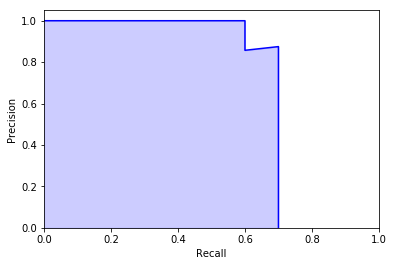

Mean Average Precision for all classes: 0.625


In [77]:
def draw_pr_curve(x, y):
    x.insert(0, 0)
    y.insert(0, 1)
    x.append(x[-1])
    y.append(0)
    plt.plot(x, y, color='b')
    plt.fill_between(x, y, alpha=0.2, color='b')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

all_ap = []
for cls_pair in metric_results:
    met_vals = metric_results[cls_pair]
    ap = met_vals['ap']
    all_ap.append(ap)
    print('Average precision for classes {!r} and {!r}: {}'.format(*cls_pair.split(':'), ap))
    print('Precision-Recall curve.')
    res_matrix = met_vals['matrix']
    draw_pr_curve(res_matrix[:, 6].tolist(), res_matrix[:, 5].tolist())
    
print('Mean Average Precision for all classes: {}'.format(np.mean(all_ap)))